# Random Forest - Model Training and Optimization

This notebook trains and optimizes a Random Forest classifier for credit scoring.

## Overview
- **Part A**: Initial training with default/reasonable hyperparameters
- **Part B**: Hyperparameter tuning with Optuna (optimizing AUC)
- **Part C**: Final model evaluation and registration

## Methodology
1. **Cross-Validation**: 5-fold stratified CV for all evaluations
2. **Class Imbalance**: Handled via `class_weight='balanced'`
3. **Metrics**: AUC (primary), Accuracy (control), Business Cost (final selection)
4. **Tracking**: All experiments logged to MLflow

## Business Context
- False Negative (FN): Missing a default → Cost = 10
- False Positive (FP): Rejecting a good client → Cost = 1
- Total Cost = 10 × FN + 1 × FP


## 1. Setup and Configuration


In [ ]:
import sys
from pathlib import Path

# Add parent directory to path for imports
parent_dir = Path().resolve().parent
sys.path.insert(0, str(parent_dir))

import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, accuracy_score, confusion_matrix,
    precision_score, recall_score, f1_score
)
import optuna
from optuna.integration import MLflowCallback
import mlflow
import warnings
warnings.filterwarnings('ignore')

# Project utilities
from src.utils.notebook_mlflow import (
    quick_mlflow_setup, NotebookMLFlow, 
    create_optuna_objective, FN_COST, FP_COST,
    calculate_business_cost, find_optimal_threshold
)
from src.utils.feature_io import load_data_splits

# Configuration
RANDOM_STATE = 42
N_FOLDS = 5
N_OPTUNA_TRIALS = 10  # Number of Optuna trials

print(" Imports complete")
print(f"   Random State: {RANDOM_STATE}")
print(f"   CV Folds: {N_FOLDS}")
print(f"   Optuna Trials: {N_OPTUNA_TRIALS}")
print(f"   Business Cost: {FN_COST}×FN + {FP_COST}×FP")


 Imports complete
   Random State: 42
   CV Folds: 5
   Optuna Trials: 10
   Business Cost: 10.0×FN + 1.0×FP


In [2]:
# Initialize MLflow tracker
mlflow_tracker = quick_mlflow_setup("credit-scoring-random-forest")
print("MLflow tracker ready")


2026/01/08 16:07:43 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/08 16:07:43 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


✅ MLFlow configuré - Expérience: credit-scoring-random-forest
MLflow tracker ready


## 2. Load Data Splits

Using the same splits created in `03_dummy_classifier.ipynb` for fair comparison.


In [3]:
# Load pre-created data splits (from 03_dummy_classifier.ipynb)
splits = load_data_splits(input_dir="../data/processed")

X_train = splits["X_train"]
y_train = splits["y_train"]
X_val = splits["X_val"]
y_val = splits["y_val"]
X_test = splits["X_test"]
y_test = splits["y_test"]
feature_names = splits["feature_names"]

print(f"\n Training set: {len(X_train):,} samples ({y_train.mean():.2%} positive)")
print(f" Validation set: {len(X_val):,} samples ({y_val.mean():.2%} positive)")
print(f" Test set: {len(X_test):,} samples ({y_test.mean():.2%} positive) - RESERVED")
print(f" Number of features: {len(feature_names)}")


✅ Loaded data splits from: ../data/processed/data_splits.pkl
   Train: 184,503 samples
   Val:   61,502 samples
   Test:  61,502 samples

 Training set: 184,503 samples (8.07% positive)
 Validation set: 61,502 samples (8.07% positive)
 Test set: 61,502 samples (8.07% positive) - RESERVED
 Number of features: 763


In [4]:
# Load baseline metrics for comparison
baseline_path = Path("../data/processed/baseline_metrics.pkl")
if baseline_path.exists():
    with open(baseline_path, 'rb') as f:
        baseline_metrics = pickle.load(f)
    print(f"\n Baseline metrics loaded:")
    print(f"   Baseline AUC (stratified): {baseline_metrics['stratified']['cv_auc_mean']:.4f}")
    print(f"   Baseline Cost (most_frequent): {baseline_metrics['most_frequent']['cv_business_cost_mean']:.1f}")
else:
    print(" Baseline metrics not found. Run 03_dummy_classifier.ipynb first.")



 Baseline metrics loaded:
   Baseline AUC (stratified): 0.4995
   Baseline Cost (most_frequent): 29790.0


---
# Part A: Initial Training (No Tuning)

Train Random Forest with reasonable default hyperparameters and evaluate with cross-validation.


In [5]:
# Define initial Random Forest model with reasonable defaults
rf_initial = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    class_weight='balanced',  # Handle class imbalance
    random_state=RANDOM_STATE,
    n_jobs=-1
)

initial_params = {
    "n_estimators": 100,
    "max_depth": 10,
    "min_samples_split": 5,
    "min_samples_leaf": 2,
    "max_features": "sqrt",
    "class_weight": "balanced",
    "random_state": RANDOM_STATE
}

print("Initial Random Forest Configuration:")
for param, value in initial_params.items():
    print(f"   {param}: {value}")


Initial Random Forest Configuration:
   n_estimators: 100
   max_depth: 10
   min_samples_split: 5
   min_samples_leaf: 2
   max_features: sqrt
   class_weight: balanced
   random_state: 42


In [6]:
# Run cross-validation on initial model
print("\n" + "="*60)
print("INITIAL MODEL CROSS-VALIDATION")
print("="*60)

initial_cv_results = mlflow_tracker.cross_validate_model(
    model=rf_initial,
    X=X_train,
    y=y_train,
    cv=N_FOLDS,
    model_name="RandomForest_initial",
    params=initial_params,
    tags={"optimization": "none", "stage": "initial"},
    log_to_mlflow=True,
    create_plots=True
)

print("\n✅ Initial model cross-validation complete")



INITIAL MODEL CROSS-VALIDATION

CROSS-VALIDATION: RandomForest_initial (5 folds)
  Fold 1/5: AUC=0.7415, Acc=0.7985, Cost=21195 (18.0s)
  Fold 2/5: AUC=0.7415, Acc=0.8048, Cost=21062 (17.6s)
  Fold 3/5: AUC=0.7405, Acc=0.8059, Cost=21419 (19.1s)
  Fold 4/5: AUC=0.7345, Acc=0.8019, Cost=21323 (17.2s)
  Fold 5/5: AUC=0.7390, Acc=0.8041, Cost=21151 (17.2s)

RESULTS: RandomForest_initial
  AUC:           0.7394 ± 0.0026
  Accuracy:      0.8031 ± 0.0026
  Business Cost: 21230.0 ± 126.5
  Optimal Threshold: 0.455 (Cost: 102179.0)
  Training Time: 89.2s

✅ Logged to MLflow: RandomForest_initial

✅ Initial model cross-validation complete


In [7]:
# Compare with baseline
print("\n" + "="*60)
print("COMPARISON WITH BASELINE")
print("="*60)

if 'baseline_metrics' in dir():
    baseline_auc = baseline_metrics['stratified']['cv_auc_mean']
    baseline_cost = baseline_metrics['most_frequent']['cv_business_cost_mean']
    
    auc_improvement = (initial_cv_results['cv_auc_mean'] - baseline_auc) / baseline_auc * 100
    cost_improvement = (baseline_cost - initial_cv_results['cv_business_cost_mean']) / baseline_cost * 100
    
    print(f"\n📊 AUC:")
    print(f"   Baseline (stratified): {baseline_auc:.4f}")
    print(f"   Random Forest:         {initial_cv_results['cv_auc_mean']:.4f}")
    print(f"   Improvement:           {auc_improvement:+.1f}%")
    
    print(f"\n📊 Business Cost:")
    print(f"   Baseline (most_freq):  {baseline_cost:.1f}")
    print(f"   Random Forest:         {initial_cv_results['cv_business_cost_mean']:.1f}")
    print(f"   Improvement:           {cost_improvement:+.1f}%")



COMPARISON WITH BASELINE

📊 AUC:
   Baseline (stratified): 0.4995
   Random Forest:         0.7394
   Improvement:           +48.0%

📊 Business Cost:
   Baseline (most_freq):  29790.0
   Random Forest:         21230.0
   Improvement:           +28.7%


---
# Part B: Hyperparameter Tuning with Optuna

Use Optuna to find optimal hyperparameters, optimizing for AUC.


In [8]:
# Define Optuna objective function for Random Forest
def rf_optuna_objective(trial):
    """Optuna objective function for Random Forest optimization with comprehensive metrics logging."""
    # Ensure all required imports are available (in case cell 2 wasn't re-executed)
    from sklearn.metrics import (
        roc_auc_score, accuracy_score, confusion_matrix,
        precision_score, recall_score, f1_score
    )
    # Import business cost functions (already imported in cell 2, but ensure availability)
    from src.utils.notebook_mlflow import calculate_business_cost, find_optimal_threshold
    
    # Define hyperparameter search space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 100),
        'max_depth': trial.suggest_int('max_depth', 5, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'class_weight': 'balanced',
        'random_state': RANDOM_STATE,
        'n_jobs': 4
    }
    
    # Create model
    model = RandomForestClassifier(**params)
    
    # Perform cross-validation
    skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    auc_scores = []
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    business_costs = []
    
    # Stocker toutes les prédictions pour calculer le seuil optimal
    all_y_true = []
    all_y_pred_proba = []
    
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_fold_train = X_train.iloc[train_idx]
        X_fold_val = X_train.iloc[val_idx]
        y_fold_train = y_train.iloc[train_idx]
        y_fold_val = y_train.iloc[val_idx]
        
        model.fit(X_fold_train, y_fold_train)
        y_pred_proba = model.predict_proba(X_fold_val)[:, 1]
        y_pred = (y_pred_proba >= 0.5).astype(int)  # Seuil par défaut pour métriques
        
        # Calculer métriques
        auc_scores.append(roc_auc_score(y_fold_val, y_pred_proba))
        accuracy_scores.append(accuracy_score(y_fold_val, y_pred))
        precision_scores.append(precision_score(y_fold_val, y_pred, zero_division=0))
        recall_scores.append(recall_score(y_fold_val, y_pred, zero_division=0))
        f1_scores.append(f1_score(y_fold_val, y_pred, zero_division=0))
        
        # Business cost
        business_costs.append(calculate_business_cost(y_fold_val, y_pred))
        
        # Accumuler pour seuil optimal
        all_y_true.extend(y_fold_val)
        all_y_pred_proba.extend(y_pred_proba)
    
    # Calculer métriques agrégées
    cv_auc_mean = np.mean(auc_scores)
    cv_auc_std = np.std(auc_scores)
    cv_accuracy_mean = np.mean(accuracy_scores)
    cv_precision_mean = np.mean(precision_scores)
    cv_recall_mean = np.mean(recall_scores)
    cv_f1_mean = np.mean(f1_scores)
    cv_business_cost_mean = np.mean(business_costs)
    
    # Calculer seuil optimal sur toutes les prédictions OOF
    all_y_true = np.array(all_y_true)
    all_y_pred_proba = np.array(all_y_pred_proba)
    optimal_threshold, optimal_cost = find_optimal_threshold(all_y_true, all_y_pred_proba)
    
    # Log chaque essai à MLflow avec toutes les métriques
    mlflow_tracker.log_optuna_trial(
        trial_number=trial.number,
        params=params,
        metrics={
            'cv_auc_mean': cv_auc_mean,
            'cv_auc_std': cv_auc_std,
            'cv_accuracy_mean': cv_accuracy_mean,
            'cv_precision_mean': cv_precision_mean,
            'cv_recall_mean': cv_recall_mean,
            'cv_f1_mean': cv_f1_mean,
            'cv_business_cost_mean': cv_business_cost_mean,
            'optimal_threshold': optimal_threshold,
            'optimal_business_cost': optimal_cost
        },
        model_name="RandomForest"
    )
    
    return cv_auc_mean  # Retourne la métrique à optimiser

print("✅ Optuna objective function defined")


✅ Optuna objective function defined


In [ ]:
# Run Optuna optimization
print("\n" + "="*60)
print("OPTUNA HYPERPARAMETER OPTIMIZATION")
print("="*60)
print(f"Trials: {N_OPTUNA_TRIALS}")
print(f"Objective: Maximize AUC")
print("="*60)

# Create Optuna study
study = optuna.create_study(
    direction='maximize',
    study_name='RandomForest_optimization',
    sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE)
)

# Optimize with progress bar
study.optimize(
    rf_optuna_objective,
    n_trials=N_OPTUNA_TRIALS,
    show_progress_bar=True,
    n_jobs=4
)

print(f"\n✅ Optimization complete!")
print(f"   Best AUC: {study.best_value:.4f}")
print(f"   Best trial: #{study.best_trial.number}")


[I 2026-01-08 17:06:25,990] A new study created in memory with name: RandomForest_optimization



OPTUNA HYPERPARAMETER OPTIMIZATION
Trials: 10
Objective: Maximize AUC


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2026-01-08 17:09:01,338] Trial 3 finished with value: 0.7005024626777159 and parameters: {'n_estimators': 99, 'max_depth': 5, 'min_samples_split': 17, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 3 with value: 0.7005024626777159.
[I 2026-01-08 17:09:12,897] Trial 0 finished with value: 0.7177316189333346 and parameters: {'n_estimators': 71, 'max_depth': 8, 'min_samples_split': 15, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 0 with value: 0.7177316189333346.
[I 2026-01-08 17:09:18,358] Trial 2 finished with value: 0.7128434932383583 and parameters: {'n_estimators': 96, 'max_depth': 7, 'min_samples_split': 18, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 0 with value: 0.7177316189333346.
[I 2026-01-08 17:09:57,638] Trial 1 finished with value: 0.7206095327921804 and parameters: {'n_estimators': 76, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 1 with value: 0.7206095327921804.

In [10]:
# Display best hyperparameters
print("\n" + "="*60)
print("BEST HYPERPARAMETERS")
print("="*60)

best_params = study.best_params
for param, value in best_params.items():
    print(f"   {param}: {value}")

print(f"\n   Best CV AUC: {study.best_value:.4f}")



BEST HYPERPARAMETERS
   n_estimators: 54
   max_depth: 10
   min_samples_split: 10
   min_samples_leaf: 6
   max_features: sqrt

   Best CV AUC: 0.7354


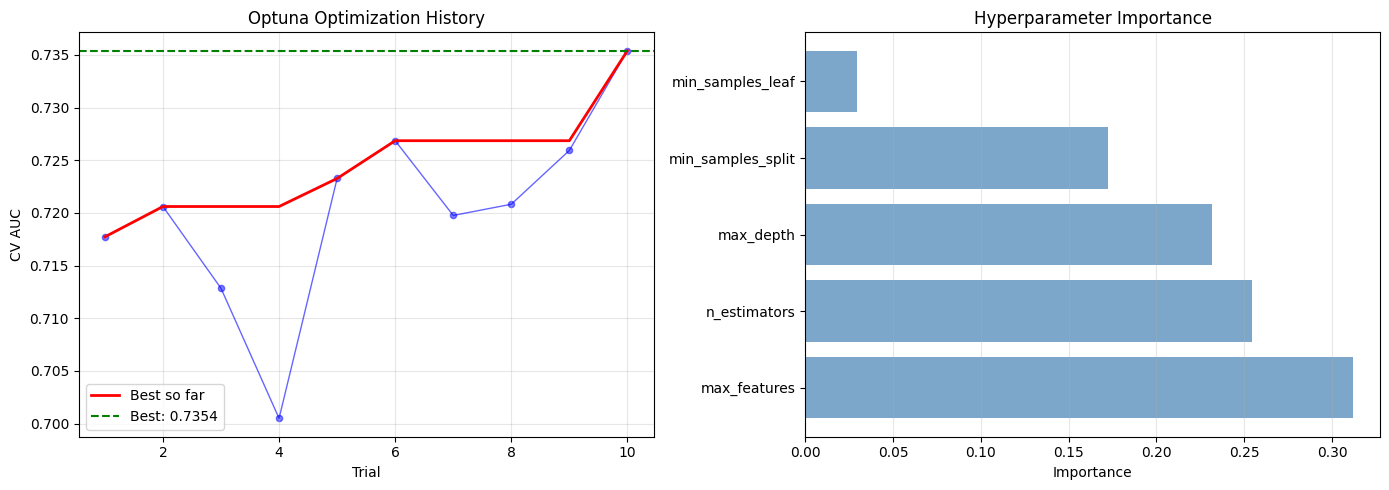


✅ Optimization plots saved


In [11]:
# Visualize Optuna optimization history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Optimization history
ax1 = axes[0]
trials = range(1, len(study.trials) + 1)
values = [t.value for t in study.trials]
ax1.plot(trials, values, 'b-', alpha=0.6, linewidth=1)
ax1.scatter(trials, values, c='blue', alpha=0.5, s=20)

# Best value line
best_values = [max(values[:i+1]) for i in range(len(values))]
ax1.plot(trials, best_values, 'r-', linewidth=2, label='Best so far')

ax1.axhline(y=study.best_value, color='green', linestyle='--', label=f'Best: {study.best_value:.4f}')
ax1.set_xlabel('Trial')
ax1.set_ylabel('CV AUC')
ax1.set_title('Optuna Optimization History')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Parameter importance
ax2 = axes[1]
param_importance = optuna.importance.get_param_importances(study)
params = list(param_importance.keys())
importances = list(param_importance.values())
ax2.barh(params, importances, color='steelblue', alpha=0.7)
ax2.set_xlabel('Importance')
ax2.set_title('Hyperparameter Importance')
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../data/processed/rf_optuna_optimization.png', dpi=100, bbox_inches='tight')
plt.show()

print("\n✅ Optimization plots saved")


---
# Part C: Final Model Evaluation and Registration

Train the best model and evaluate on validation set.


In [12]:
# Train best model with optimized hyperparameters
print("\n" + "="*60)
print("TRAINING BEST MODEL")
print("="*60)

# Add fixed parameters
best_params_full = {**best_params, 'class_weight': 'balanced', 'random_state': RANDOM_STATE, 'n_jobs': -1}

# Create and train best model
rf_best = RandomForestClassifier(**best_params_full)

# Run CV with best params for final metrics
best_cv_results = mlflow_tracker.cross_validate_model(
    model=rf_best,
    X=X_train,
    y=y_train,
    cv=N_FOLDS,
    model_name="RandomForest_best",
    params=best_params_full,
    tags={"optimization": "optuna", "stage": "best"},
    log_to_mlflow=True,
    create_plots=True
)

print("\n✅ Best model cross-validation complete")



TRAINING BEST MODEL

CROSS-VALIDATION: RandomForest_best (5 folds)
  Fold 1/5: AUC=0.7384, Acc=0.7985, Cost=21321 (11.1s)
  Fold 2/5: AUC=0.7374, Acc=0.8004, Cost=21054 (10.8s)
  Fold 3/5: AUC=0.7383, Acc=0.8013, Cost=21401 (10.4s)
  Fold 4/5: AUC=0.7298, Acc=0.7974, Cost=21497 (10.8s)
  Fold 5/5: AUC=0.7332, Acc=0.7991, Cost=21471 (10.7s)

RESULTS: RandomForest_best
  AUC:           0.7354 ± 0.0034
  Accuracy:      0.7993 ± 0.0014
  Business Cost: 21348.8 ± 159.6
  Optimal Threshold: 0.455 (Cost: 103148.0)
  Training Time: 53.8s

✅ Logged to MLflow: RandomForest_best

✅ Best model cross-validation complete


In [18]:
# Evaluate on validation set
print("\n" + "="*60)
print("VALIDATION SET EVALUATION")
print("="*60)

# Train on full training set
rf_best.fit(X_train, y_train)

# Predict on validation set
y_val_pred_proba = rf_best.predict_proba(X_val)[:, 1]

# Find optimal threshold
optimal_threshold = best_cv_results['optimal_threshold']
y_val_pred = (y_val_pred_proba >= optimal_threshold).astype(int)

# Calculate metrics
val_auc = roc_auc_score(y_val, y_val_pred_proba)
val_acc = accuracy_score(y_val, y_val_pred)
val_cost = calculate_business_cost(y_val, y_val_pred)

print(f"\n Validation Set Results:")
print(f"   AUC:              {val_auc:.4f}")
print(f"   Accuracy:         {val_acc:.4f}")
print(f"   Business Cost:    {val_cost:.1f}")



VALIDATION SET EVALUATION

 Validation Set Results:
   AUC:              0.7362
   Accuracy:         0.7118
   Business Cost:    34705.0


In [14]:
# Register best model in MLflow
print("\n" + "="*60)
print("MODEL REGISTRATION")
print("="*60)

run_id = mlflow_tracker.log_best_model(
    model=rf_best,
    model_name="RandomForest",
    X_train=X_train,
    y_train=y_train,
    best_params=best_params_full,
    cv_results=best_cv_results,
    tags={"framework": "sklearn", "final_model": "true"}
)



MODEL REGISTRATION


2026/01/08 17:21:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
python(68638) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2026/01/08 17:21:12 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2026/01/08 17:21:12 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/08 17:21:12 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.



✅ Best model logged to MLflow
   Run ID: 221bea45a9584472ab41b3d548a8c659
   Model URI: runs:/221bea45a9584472ab41b3d548a8c659/model


Successfully registered model 'RandomForest_best'.
Created version '1' of model 'RandomForest_best'.


In [15]:
# Save model and results locally
rf_results = {
    "model_name": "RandomForest",
    "best_params": best_params_full,
    "initial_cv_results": initial_cv_results,
    "best_cv_results": best_cv_results,
    "validation_metrics": {
        "auc": val_auc,
        "accuracy": val_acc,
        "business_cost": val_cost,
        "optimal_threshold": optimal_threshold,
        "optimal_cost": optimal_cost
    },
    "optuna_study_best_value": study.best_value,
    "n_optuna_trials": N_OPTUNA_TRIALS,
    "mlflow_run_id": run_id
}

# Save results
results_path = Path("../data/processed/rf_results.pkl")
with open(results_path, 'wb') as f:
    pickle.dump(rf_results, f)

# Save model
model_path = Path("../data/processed/rf_best_model.pkl")
with open(model_path, 'wb') as f:
    pickle.dump(rf_best, f)

print(f"\n✅ Results saved to: {results_path}")
print(f"✅ Model saved to: {model_path}")



✅ Results saved to: ../data/processed/rf_results.pkl
✅ Model saved to: ../data/processed/rf_best_model.pkl


In [16]:
# Investigation: Comparaison équitable des coûts
print("\n" + "="*60)
print("INVESTIGATION: COÛT CV vs VALIDATION")
print("="*60)

# 1. Utiliser le seuil optimal de CV sur le validation set
cv_optimal_threshold = best_cv_results['optimal_threshold']
print(f"\n1. Seuil optimal CV: {cv_optimal_threshold:.3f}")
print(f"   Seuil optimal Validation (recalculé): {optimal_threshold:.3f}")

# 2. Appliquer le seuil CV au validation set
y_val_pred_cv_threshold = (y_val_pred_proba >= cv_optimal_threshold).astype(int)
val_cost_cv_threshold = calculate_business_cost(y_val, y_val_pred_cv_threshold)

print(f"\n2. Coûts avec seuil CV ({cv_optimal_threshold:.3f}) sur validation:")
print(f"   Coût: {val_cost_cv_threshold:.1f}")

# 3. Coûts normalisés par échantillon
n_train = len(X_train)
n_val = len(X_val)
cv_cost_per_sample = best_cv_results['optimal_business_cost'] / n_train
val_cost_per_sample = optimal_cost / n_val

print(f"\n3. Coûts normalisés par échantillon:")
print(f"   CV: {cv_cost_per_sample:.4f} par échantillon")
print(f"   Validation: {val_cost_per_sample:.4f} par échantillon")
print(f"   Différence: {abs(cv_cost_per_sample - val_cost_per_sample):.4f}")

# 4. Comparaison avec le coût CV moyen (par fold)
cv_cost_mean = best_cv_results['cv_business_cost_mean']
cv_cost_mean_per_sample = cv_cost_mean / (n_train / N_FOLDS)  # Coût moyen par fold, normalisé

print(f"\n4. Coût CV moyen (avec seuil 0.5):")
print(f"   Coût total: {cv_cost_mean:.1f}")
print(f"   Coût par échantillon (fold moyen): {cv_cost_mean_per_sample:.4f}")

# 5. Matrice de confusion avec seuil CV
from sklearn.metrics import confusion_matrix
cm_cv_threshold = confusion_matrix(y_val, y_val_pred_cv_threshold)
tn, fp, fn, tp = cm_cv_threshold.ravel()

print(f"\n5. Matrice de confusion (validation, seuil CV {cv_optimal_threshold:.3f}):")
print(f"   TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")
print(f"   Coût: {val_cost_cv_threshold:.1f} (10×{fn} + 1×{fp} = {10*fn + fp})")

# 6. Matrice de confusion avec seuil optimal validation
cm_val_threshold = confusion_matrix(y_val, y_val_pred)
tn2, fp2, fn2, tp2 = cm_val_threshold.ravel()

print(f"\n6. Matrice de confusion (validation, seuil optimal {optimal_threshold:.3f}):")
print(f"   TN: {tn2}, FP: {fp2}, FN: {fn2}, TP: {tp2}")
print(f"   Coût: {optimal_cost:.1f} (10×{fn2} + 1×{fp2} = {10*fn2 + fp2})")

# 7. Distribution des probabilités
print(f"\n7. Distribution des probabilités (validation set):")
print(f"   Min: {y_val_pred_proba.min():.4f}")
print(f"   Max: {y_val_pred_proba.max():.4f}")
print(f"   Mean: {y_val_pred_proba.mean():.4f}")
print(f"   Median: {np.median(y_val_pred_proba):.4f}")
print(f"   Std: {y_val_pred_proba.std():.4f}")

# 8. Nombre de prédictions positives avec chaque seuil
n_pos_cv_threshold = y_val_pred_cv_threshold.sum()
n_pos_val_threshold = y_val_pred.sum()
n_pos_default = (y_val_pred_proba >= 0.5).astype(int).sum()

print(f"\n8. Prédictions positives:")
print(f"   Seuil CV ({cv_optimal_threshold:.3f}): {n_pos_cv_threshold} ({n_pos_cv_threshold/n_val:.2%})")
print(f"   Seuil optimal validation ({optimal_threshold:.3f}): {n_pos_val_threshold} ({n_pos_val_threshold/n_val:.2%})")
print(f"   Seuil par défaut (0.5): {n_pos_default} ({n_pos_default/n_val:.2%})")


INVESTIGATION: COÛT CV vs VALIDATION

1. Seuil optimal CV: 0.455
   Seuil optimal Validation (recalculé): 0.475

2. Coûts avec seuil CV (0.455) sur validation:
   Coût: 34705.0

3. Coûts normalisés par échantillon:
   CV: 0.5591 par échantillon
   Validation: 0.5599 par échantillon
   Différence: 0.0008

4. Coût CV moyen (avec seuil 0.5):
   Coût total: 21348.8
   Coût par échantillon (fold moyen): 0.5785

5. Matrice de confusion (validation, seuil CV 0.455):
   TN: 40702, FP: 15835, FN: 1887, TP: 3078
   Coût: 34705.0 (10×1887 + 1×15835 = 34705)

6. Matrice de confusion (validation, seuil optimal 0.475):
   TN: 43353, FP: 13184, FN: 2125, TP: 2840
   Coût: 34434.0 (10×2125 + 1×13184 = 34434)

7. Distribution des probabilités (validation set):
   Min: 0.1263
   Max: 0.8360
   Mean: 0.4017
   Median: 0.3868
   Std: 0.1193

8. Prédictions positives:
   Seuil CV (0.455): 18913 (30.75%)
   Seuil optimal validation (0.475): 16024 (26.05%)
   Seuil par défaut (0.5): 12786 (20.79%)


In [ ]:
# Show MLflow UI info
mlflow_tracker.show_ui_info()
